# 0. Required imports

In [58]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import (
  layers,
  models,
  datasets,
  callbacks,
  losses,
  optimizers,
  metrics,
)

# 1. Parameters

In [59]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

CLASS_NAMES = [
  'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
  'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

BETA = 0.003
Z_DIM = 2

LEARNING_RATE = 0.001
MAX_EPOCHS = 1000
PATIENCE = 5
BATCH_SIZE = 32
SHUFFLE = True

# 2. Loading the data

In [60]:
(X_train, y_train), (X_test, y_test) = datasets.fashion_mnist.load_data()

In [61]:
print(f'X_train size: {X_train.shape}')
print(f'y_train size: {y_train.shape}')
print(f'X_test size: {X_test.shape}')
print(f'y_test size: {y_test.shape}')

X_train size: (60000, 28, 28)
y_train size: (60000,)
X_test size: (10000, 28, 28)
y_test size: (10000,)


In [62]:
def plot_data_distribution(data, title='Distribution of observations', fig_size=(12, 6), class_names=None, names_rotation=None, font_scale=1.25):
  # Calculate the number of unique classes in the dataset labels
  unique_classes, class_counts = np.unique(data, return_counts=True)

  # Calculate font for text
  header_font_size = fig_size[0] * (font_scale * 1.25)
  label_font_size = fig_size[0] * font_scale
  ticks_font_size =  fig_size[0] * (font_scale * 0.75)

  plt.figure(figsize=fig_size)

  # Verify if a list of class names is provided and display them. If not provided, do not display anything
  if class_names:
    # Example: Dress (3)
    formatted_labels = [f'{class_names[i]} ({unique_classes[i]})' for i in unique_classes]
    plt.bar(formatted_labels, class_counts)
  else:
    plt.bar(unique_classes, class_counts)

  plt.title(title, fontsize=header_font_size)
  plt.xlabel('Class', fontsize=label_font_size)
  plt.ylabel('Number of observations', fontsize=label_font_size)

  plt.xticks(unique_classes, rotation=names_rotation, ha='right', fontsize=ticks_font_size)
  plt.yticks(fontsize=ticks_font_size)

  plt.show()

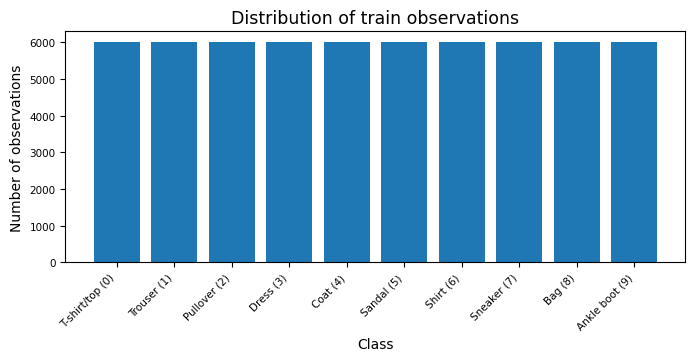

In [63]:
plot_data_distribution(y_train, title='Distribution of train observations', fig_size=(8, 3), class_names=CLASS_NAMES, names_rotation=45)

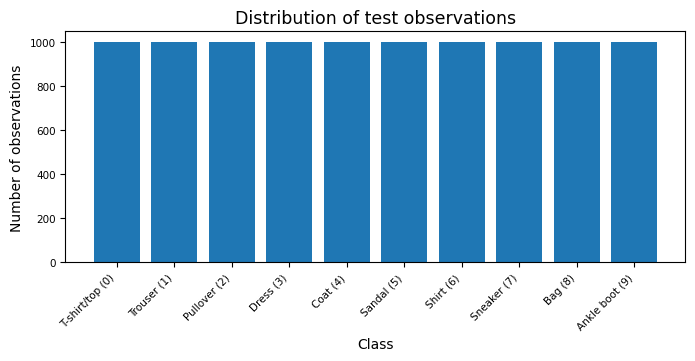

In [64]:
plot_data_distribution(y_test, title='Distribution of test observations', fig_size=(8, 3), class_names=CLASS_NAMES, names_rotation=45)

# 3. Preprocessing data

In [65]:
def preprocess_images(imgs):
  imgs = imgs.astype('float32') / 255.0
  # Fashion mnist images have size of 28x28
  # We transform them into 32x32 images, which is better for 2D convolutional layers as each layer divides by 2
  imgs = np.pad(imgs, ((0, 0), (2, 2), (2, 2)), constant_values=0.0)
  imgs = np.expand_dims(imgs, -1)

  return imgs

In [66]:
print(f'X_train size: ', X_train.shape)
print(f'y_train size: ', y_train.shape)
print(f'X_test size: ', X_test.shape)
print(f'y_test size: ', y_test.shape)

X_train size:  (60000, 28, 28)
y_train size:  (60000,)
X_test size:  (10000, 28, 28)
y_test size:  (10000,)


In [67]:
X_train = preprocess_images(X_train)
X_test = preprocess_images(X_test)

In [68]:
print(f'X_train size: ', X_train.shape)
print(f'y_train size: ', y_train.shape)
print(f'X_test size: ', X_test.shape)
print(f'y_test size: ', y_test.shape)

X_train size:  (60000, 32, 32, 1)
y_train size:  (60000,)
X_test size:  (10000, 32, 32, 1)
y_test size:  (10000,)


In [69]:
def plot_images(imgs, labels, num_columns, title='Example observations', fig_size=(6, 10), class_names=None, font_scale=1.25):
  # Extract the unique classes from the dataset labels
  unique_classes = np.unique(labels)

  # Calculate font for text
  header_size = fig_size[0] * (font_scale * 1.25)
  label_size = fig_size[0] * font_scale
  ticks_size =  fig_size[0] * (font_scale * 0.75)

  fig = plt.figure(figsize=fig_size, constrained_layout=True)
  fig.suptitle(title, fontsize=header_size)

  # Count the unique classes and create a subplot for each class
  subfigs = fig.subfigures(nrows=len(unique_classes), ncols=1)

  # Identify and plot examples for each class
  for class_idx, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=num_columns)

    # Verify if a list of class names is provided and display them. If not provided, do not display anything
    if class_names:
      subfig.suptitle(f'Class: {class_names[class_idx]} ({class_idx})', fontsize=fig_size[0])
    else:
      subfig.suptitle(f'Class: {class_idx}', fontsize=fig_size[0])

    # Obtain the indexes of all observations that belong to the current class
    observations_idxs = np.where(labels == class_idx)[0]
    # Select a number of ‘num_columns’ random items from all observations
    random_examples = np.random.choice(observations_idxs, num_columns, replace=False)
    # Plot the selected indexes
    for col, ax in enumerate(axs):
      ax.axis('off')
      ax.imshow(X_train[random_examples[col]], cmap='gray')
      ax.plot()

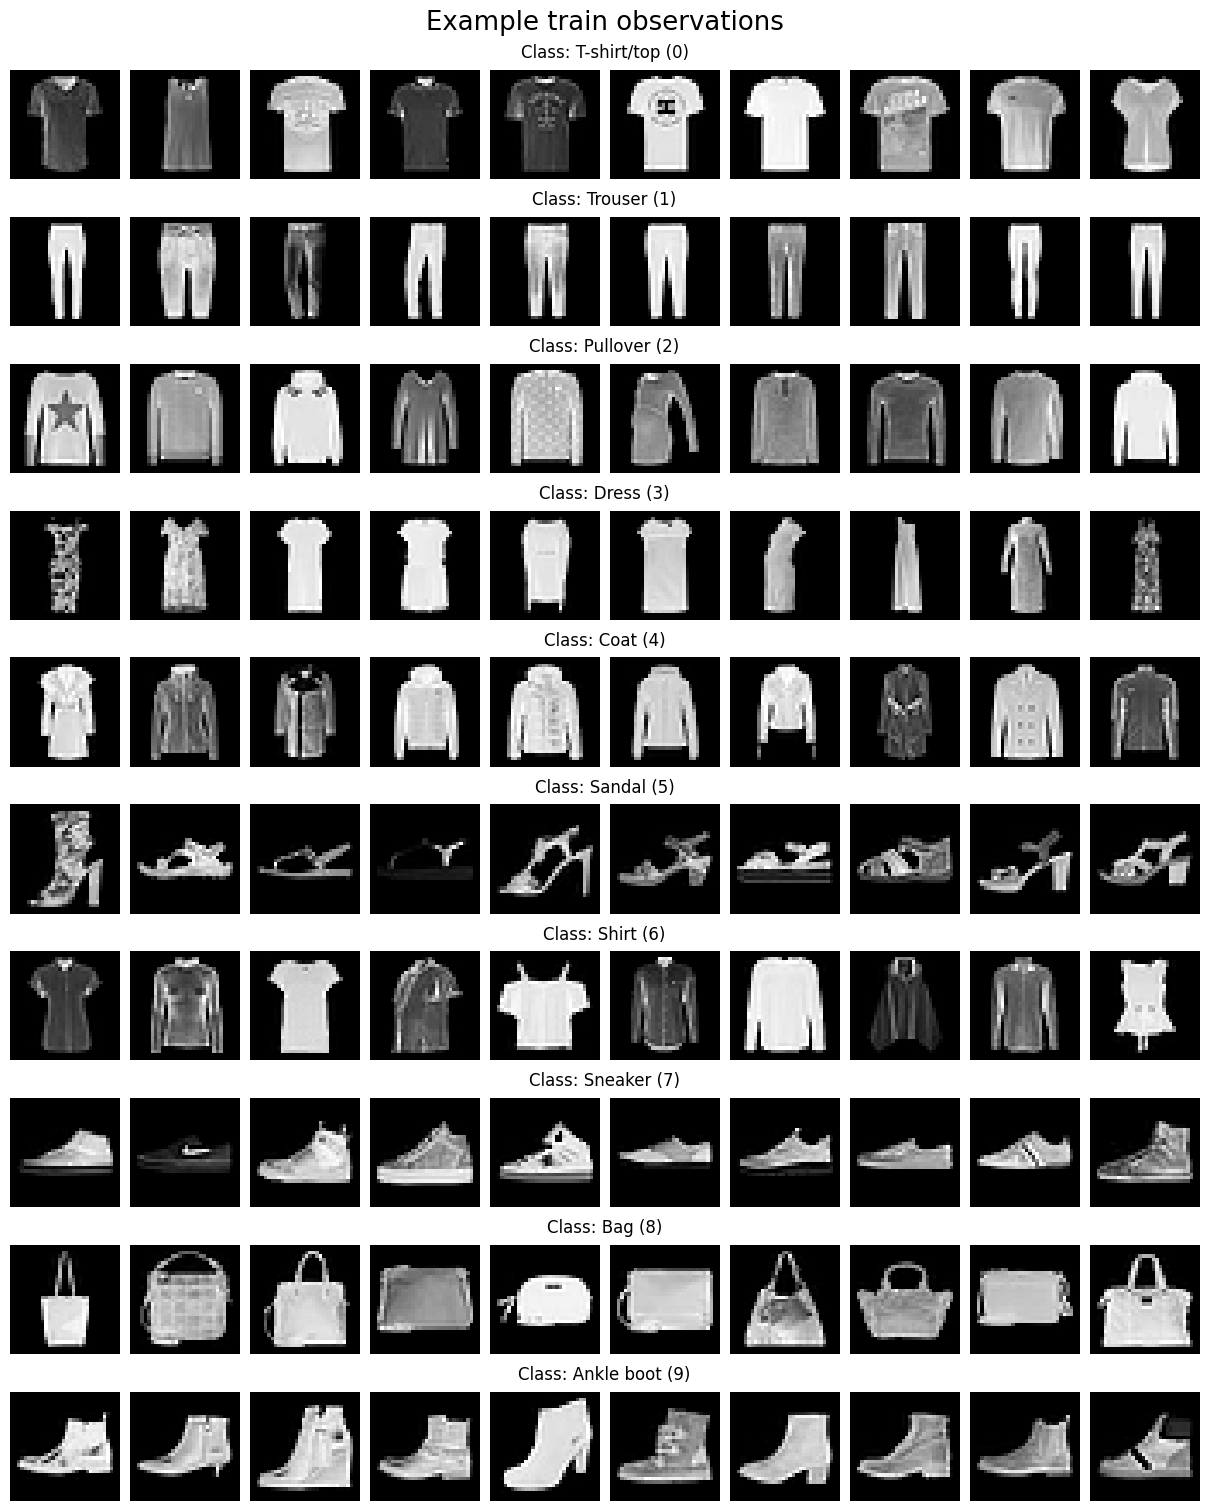

In [70]:
plot_images(X_train, y_train, num_columns=10, title='Example train observations', class_names=CLASS_NAMES, fig_size=(12,15))

# 4. Autoencoder architecture

## 4.1. Encoder architecture

In [71]:
encoder_input = layers.Input(shape=(32, 32, 1), name='encoder_input')

x = layers.Conv2D(32, (3, 3), strides=2, padding="same")(encoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(128, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

shape_before_flattening = K.int_shape(x)[1:]

x = layers.Flatten()(x)
encoder_output = layers.Dense(2, name="encoder_output")(x)

encoder = models.Model(encoder_input, encoder_output, name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_15 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                         

## 4.2. Decoder architecture

In [72]:
decoder_input = layers.Input(shape=(Z_DIM,), name="decoder_input")

x = layers.Dense(np.prod(shape_before_flattening))(decoder_input)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Reshape(shape_before_flattening)(x)

x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.LeakyReLU()(x)

decoder_output = layers.Conv2D(
  1,
  (3, 3),
  strides=1,
  activation="sigmoid",
  padding="same",
  name="decoder_output",
)(x)

decoder = models.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_2 (Dense)             (None, 2048)              6144      
                                                                 
 batch_normalization_17 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 2048)              0         
                                                                 
 reshape_2 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 8, 8, 128)         147584    
 Transpose)                                                

## 4.3. Autoencoder architecture

In [73]:
autoencoder = models.Model(encoder_input, decoder(encoder_output), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 32, 32, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 32)        320       
                                                                 
 batch_normalization_14 (Ba  (None, 16, 16, 32)        128       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 batch_normalization_15 (Ba  (None, 8, 8, 64)          256       
 tchNormalization)                                     

# 5. Training

In [74]:
callback = callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)
optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
loss = losses.binary_crossentropy
autoencoder.compile(optimizer=optimizer, loss=loss)

In [75]:
autoencoder.fit(
  X_train,
  X_train,
  epochs=MAX_EPOCHS,
  batch_size=BATCH_SIZE,
  shuffle=SHUFFLE,
  validation_split=0.1,
  callbacks=[callback]
)

Epoch 1/1000
1688/1688 [==============================] - 21s 10ms/step - loss: 0.2734 - val_loss: 0.2636
Epoch 2/1000
1688/1688 [==============================] - 16s 9ms/step - loss: 0.2654 - val_loss: 0.2592
Epoch 3/1000
1688/1688 [==============================] - 15s 9ms/step - loss: 0.2625 - val_loss: 0.2590
Epoch 4/1000
1688/1688 [==============================] - 16s 9ms/step - loss: 0.2608 - val_loss: 0.2579
Epoch 5/1000
1688/1688 [==============================] - 15s 9ms/step - loss: 0.2596 - val_loss: 0.2556
Epoch 6/1000
1688/1688 [==============================] - 17s 10ms/step - loss: 0.2587 - val_loss: 0.2556
Epoch 7/1000
1688/1688 [==============================] - 16s 9ms/step - loss: 0.2579 - val_loss: 0.2576
Epoch 8/1000
1688/1688 [==============================] - 15s 9ms/step - loss: 0.2569 - val_loss: 0.2557
Epoch 9/1000
1688/1688 [==============================] - 17s 10ms/step - loss: 0.2559 - val_loss: 0.2554
Epoch 10/1000
1688/1688 [===========================

# 6. Reconstruction using the Autoencoder

In [76]:
# Reconstruct all images from the test dataset
reconstructions = autoencoder.predict(X_test)

313/313 [==============================] - 1s 3ms/step


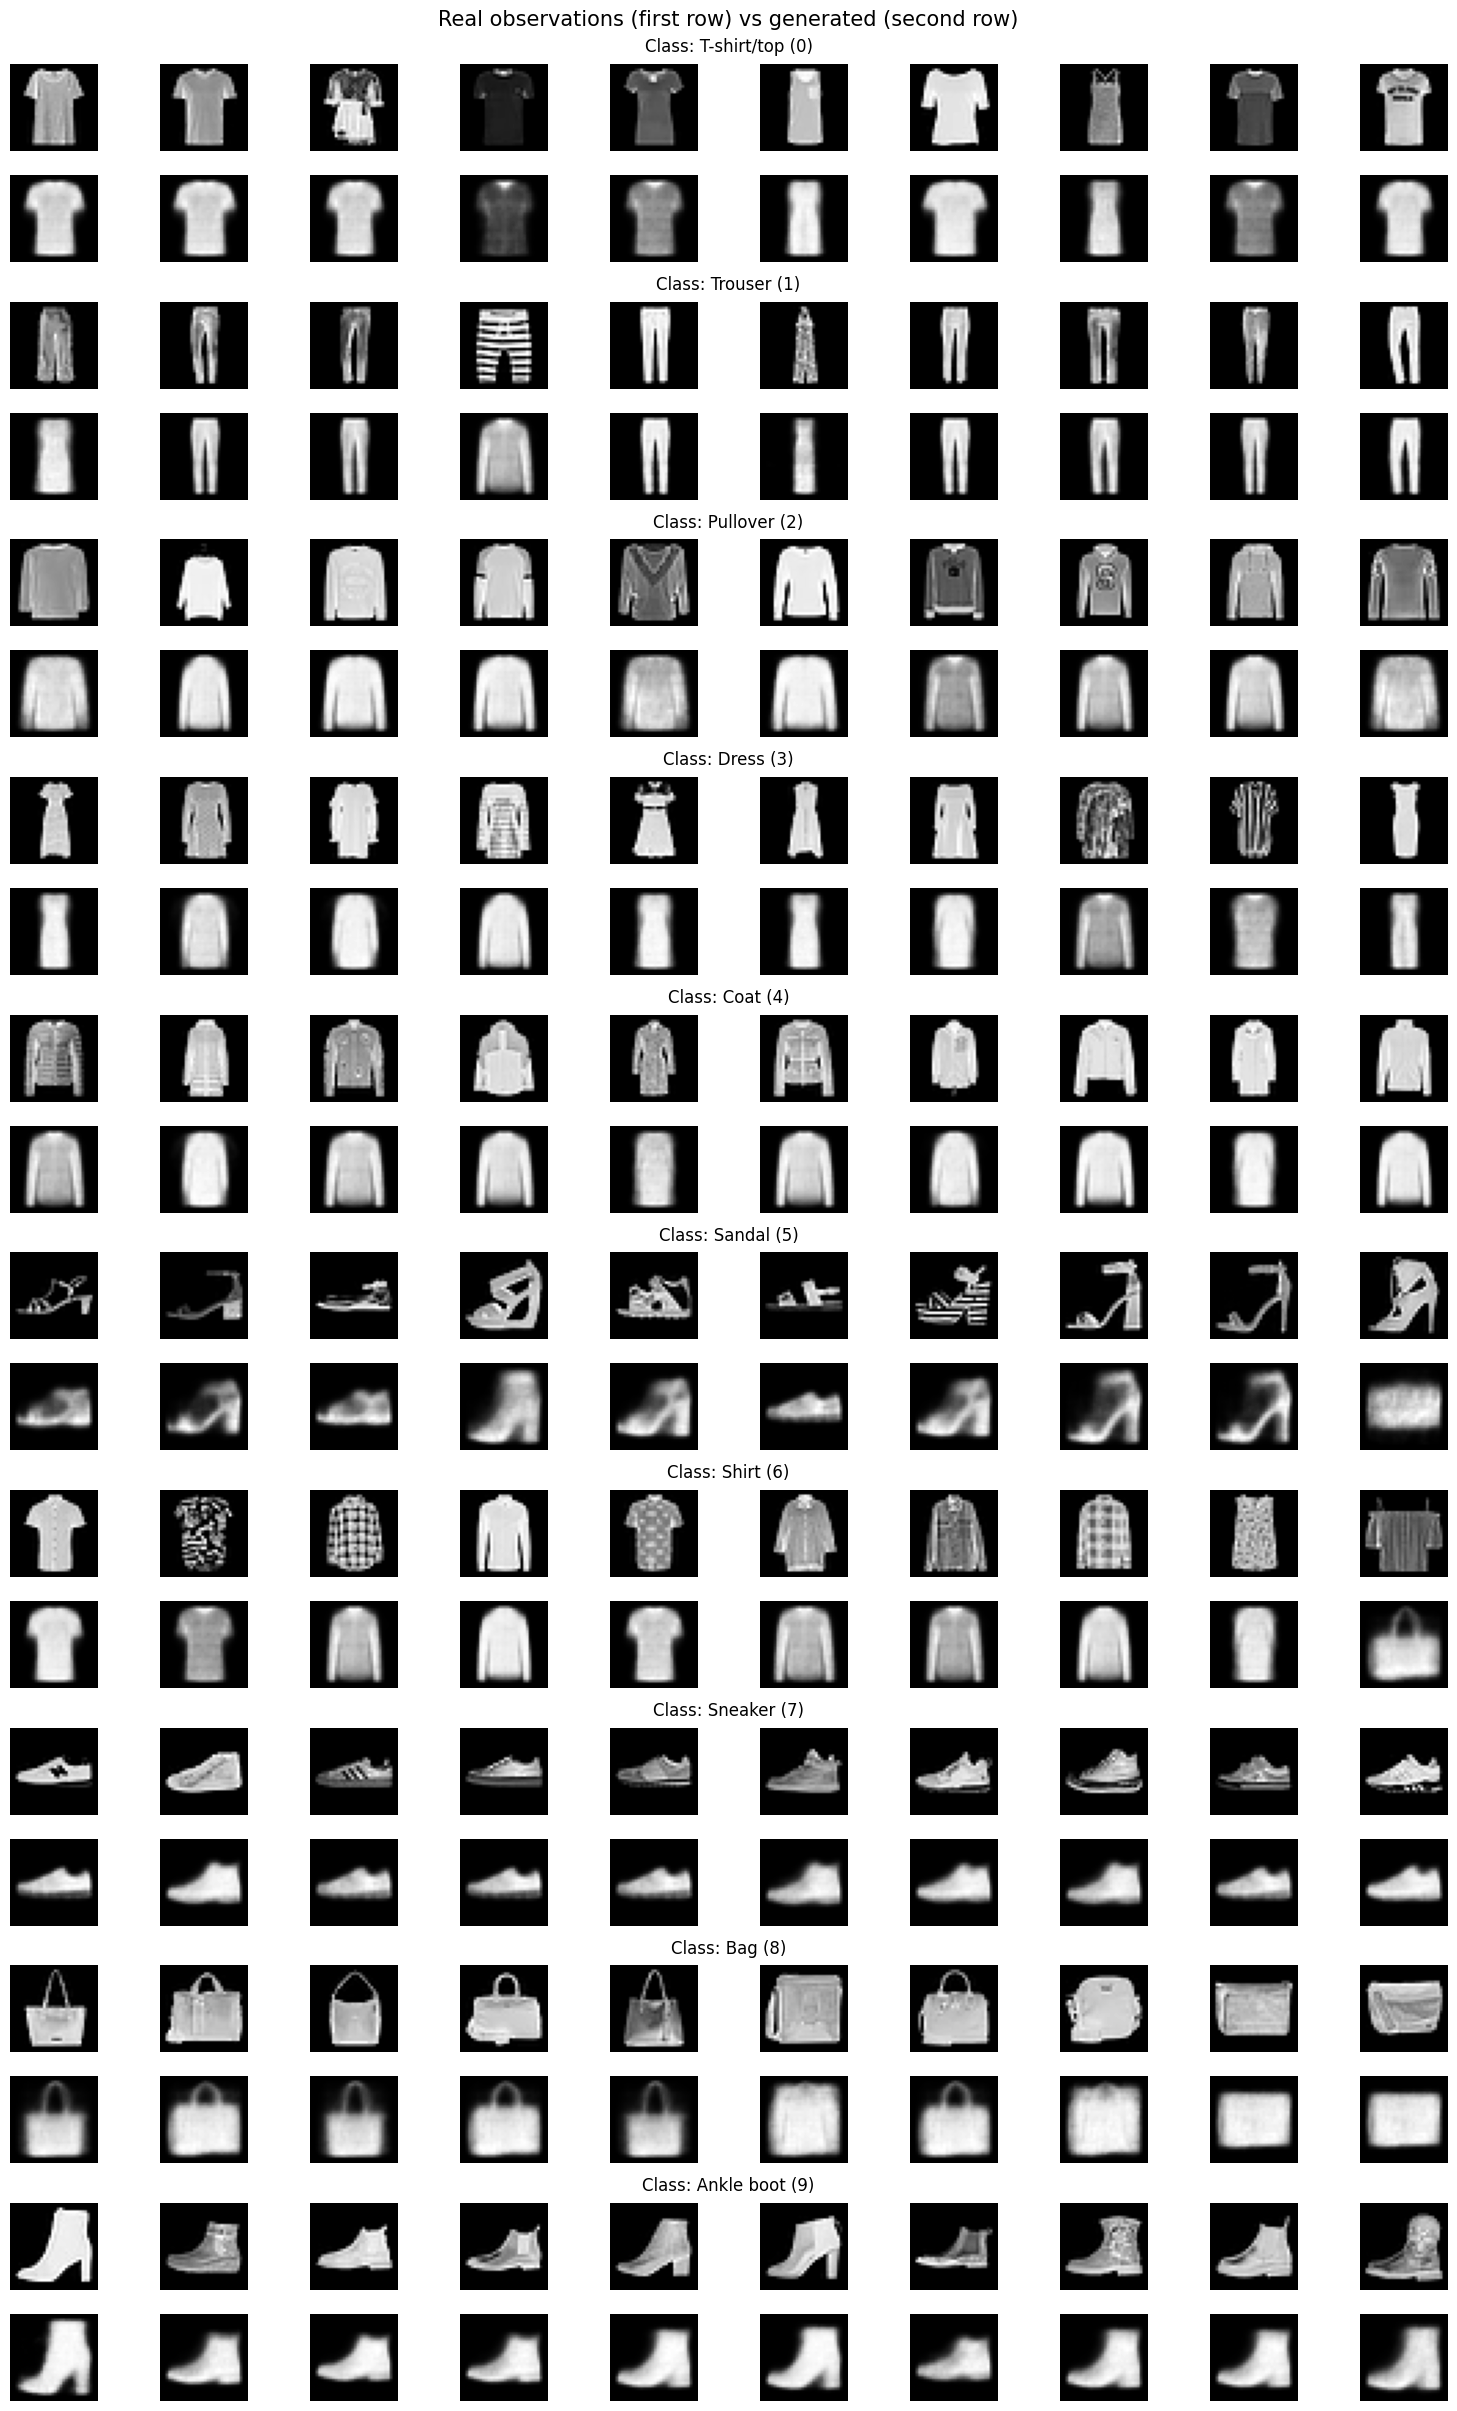

In [77]:
# Determine the number of samples to be selected per class.
IMGS_PER_ROW = 10

# Extract the unique classes from the dataset
unique_classes = np.unique(y_test)

# Create a figure to display the data
fig = plt.figure(figsize=(15, 24), constrained_layout=True)
fig.suptitle('Real observations (first row) vs generated (second row)', fontsize=15)

# Generate subfigures for each class
subfigs = fig.subfigures(nrows=len(unique_classes), ncols=1)

# Iterate through each subfigure
for class_idx, subfig in enumerate(subfigs):
  # Construct subplots within each subfigure
  axs = subfig.subplots(nrows=2, ncols=IMGS_PER_ROW)

  # Verify if a list of class names is provided and display them. If not provided, do not display anything
  if CLASS_NAMES:
    subfig.suptitle(f'Class: {CLASS_NAMES[class_idx]} ({class_idx})', fontsize=12)
  else:
    subfig.suptitle(f'Class: {class_idx}', fontsize=12)

  # Obtain the indexes of all observations that belong to the current class
  examples_idx = np.where(y_test == class_idx)[0]
  # Select ‘IMGS_PER_ROW’ random items from all observations
  random_examples = np.random.choice(examples_idx, IMGS_PER_ROW, replace=False)

  # Plot the original images for the selected indexes in the first row
  for col, ax in enumerate(axs[0]):
    ax.axis('off')
    ax.imshow(X_test[random_examples[col]], cmap='gray')
    ax.plot()

  # Plot the predicted images for the selected indexes in the second row
  for col, ax in enumerate(axs[1]):
    ax.axis('off')
    ax.imshow(reconstructions[random_examples[col]], cmap='gray')
    ax.plot()

# 7. Latent space

In [78]:
# Retrieve the embeddings for all observations in the test dataset
embeddings = encoder.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [79]:
print("First 10 embeddings: ")
for embedding in embeddings[:10]:
  print(embedding)

First 10 embeddings: 
[20.210554 10.599516]
[ -7.454881 -36.483147]
[-21.301495  26.128674]
[-9.284776 23.289013]
[ -1.143701 -16.819292]
[-21.800104  17.630066]
[ 0.17521977 -4.721515  ]
[ -2.1860955 -12.923844 ]
[ 9.169148 22.331793]
[15.44878  22.200909]


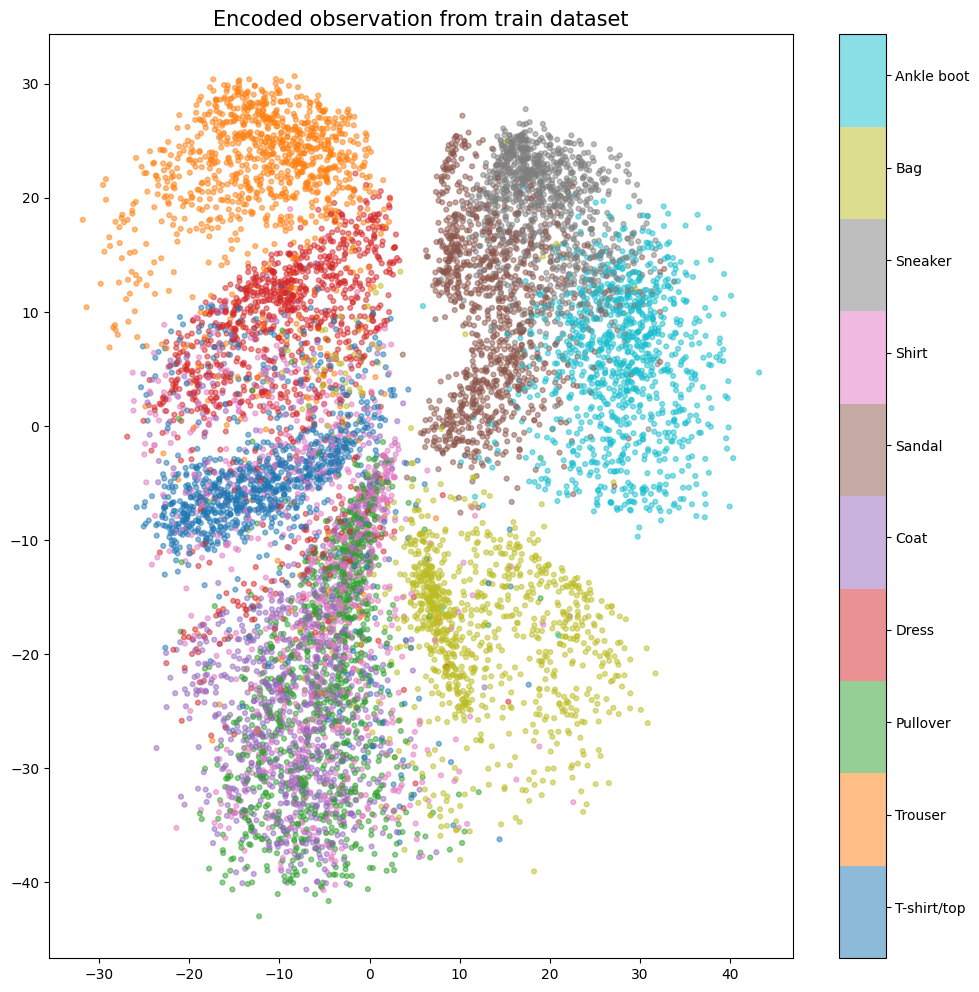

In [80]:
figsize = 12
colors = sns.color_palette("tab10", n_colors=len(CLASS_NAMES))

plt.figure(figsize=(figsize, figsize))
plt.title('Encoded observation from train dataset', fontsize=15)

plt.scatter(
  embeddings[:, 0],
  embeddings[:, 1],
  cmap=ListedColormap(colors),
  c=y_test,
  alpha=0.5,
  s=12,
)

# Align the class names in the center of the color bar
num_ticks = len(CLASS_NAMES)
tick_positions = [i * (num_ticks - 1) / (num_ticks) + 0.5 for i in range(num_ticks)]
plt.colorbar(ticks=tick_positions).set_ticklabels(CLASS_NAMES)

plt.show()

# 8. Image generation using the Decoder

In [81]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)
print(mins)
print(maxs)

[-31.81717 -42.96829]
[43.226128 30.660976]


In [82]:
grid_width, grid_height = (6, 3)
sample = sample = np.random.uniform(mins, maxs, size=(grid_width * grid_height, 2))

print(sample)

[[ 20.97624493  20.78789131]
 [ 31.49240398 -17.08014117]
 [ 42.60331305 -40.86499484]
 [ 42.22861999 -24.85570034]
 [  1.23467912  22.09706368]
 [-13.48192764 -26.41778188]
 [ 16.44383254   8.97351515]
 [-31.25654442  -9.80241048]
 [  4.88718101 -22.95326251]
 [  9.16470422 -31.58685296]
 [ -7.53272295   9.54699199]
 [ 33.75465332   0.42725124]
 [-26.20058821   7.00727098]
 [ 35.5415305   -5.83601619]
 [  5.23110356  30.02876458]
 [ 15.93271454  16.37902704]
 [ 16.69783331 -26.70242883]
 [-10.49900571   6.04713719]]


In [83]:
reconstructions = decoder.predict(sample)

1/1 [==============================] - 0s 243ms/step


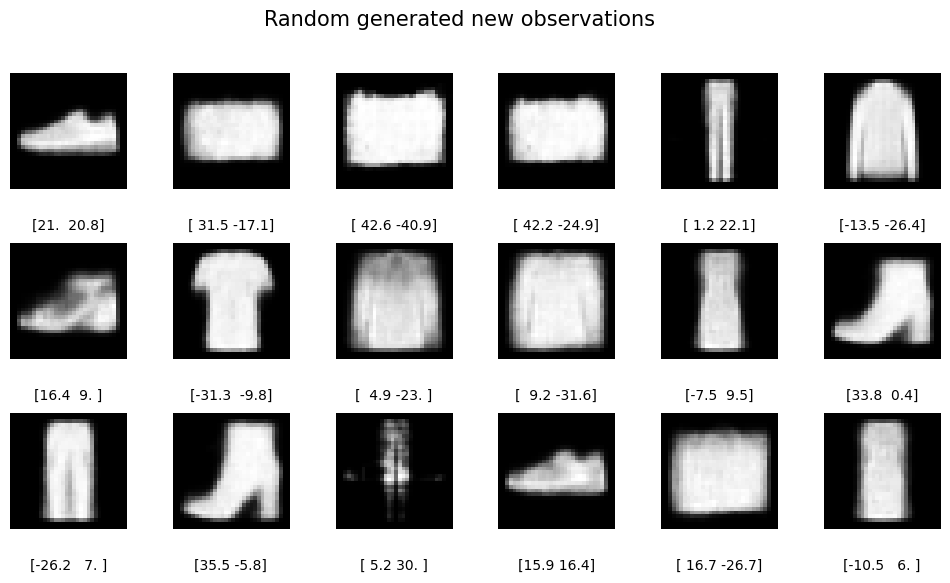

In [84]:
fig = plt.figure(figsize=(figsize, grid_height * 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Random generated new observations', fontsize=15)

for i in range(grid_width * grid_height):
  ax = fig.add_subplot(grid_height, grid_width, i + 1)
  ax.axis("off")
  ax.text(
    0.5,
    -0.35,
    str(np.round(sample[i, :], 1)),
    fontsize=10,
    ha="center",
    transform=ax.transAxes,
  )
  ax.imshow(reconstructions[i, :, :], cmap="gray")

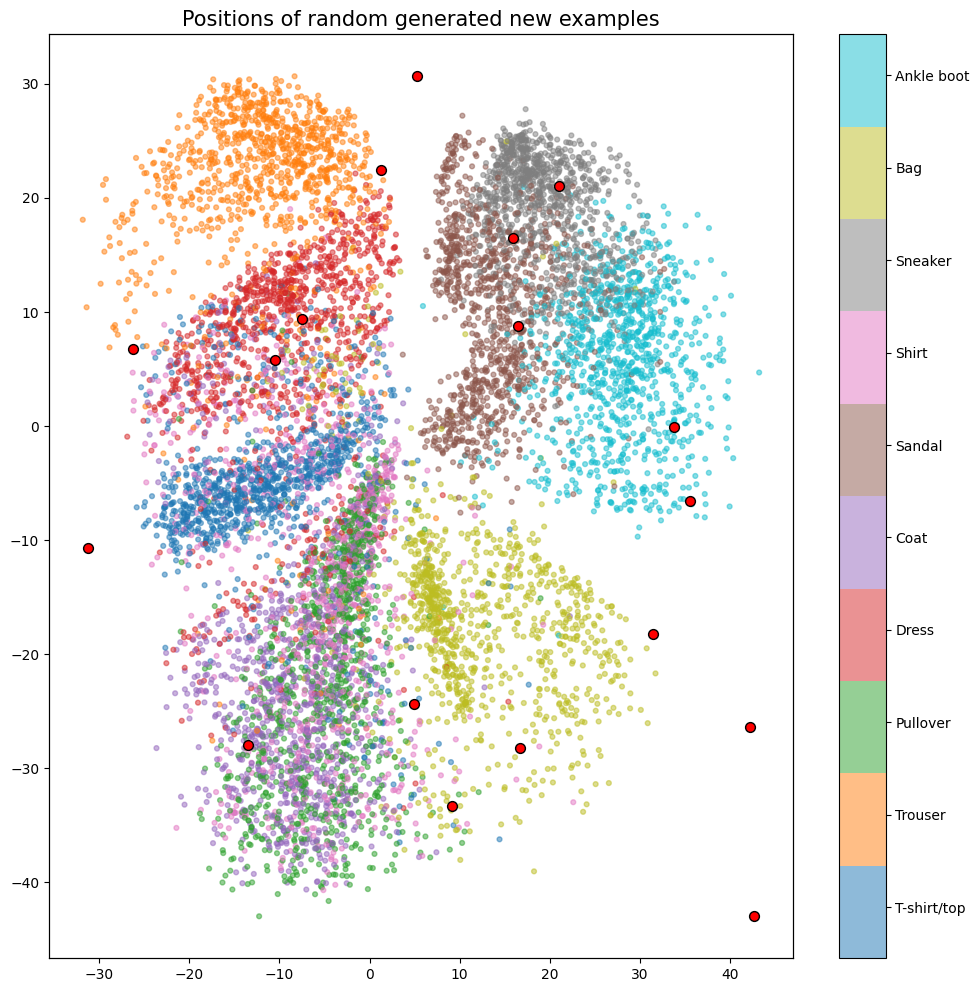

In [85]:
figsize = 12
colors = sns.color_palette("tab10", n_colors=len(CLASS_NAMES))

fig, ax = plt.subplots(figsize=(figsize, figsize))
plt.title('Positions of random generated new examples', fontsize=15)

plt.scatter(
  embeddings[:, 0],
  embeddings[:, 1],
  cmap=ListedColormap(colors),
  c=y_test,
  alpha=0.5,
  s=12,
)

# Points that have been sampled
ax2 = ax.twinx()
ax2.scatter(sample[:, 0], sample[:, 1], c="black", alpha=1, s=50)
ax2.scatter(sample[:, 0], sample[:, 1], c="red", alpha=1, s=25)
ax2.get_yaxis().set_visible(False)

# Align the class names in the center of the color bar
num_ticks = len(CLASS_NAMES)
tick_positions = [i * (num_ticks - 1) / (num_ticks) + 0.5 for i in range(num_ticks)]
plt.colorbar(ticks=tick_positions).set_ticklabels(CLASS_NAMES)

plt.show()

8/8 [==============================] - 0s 5ms/step


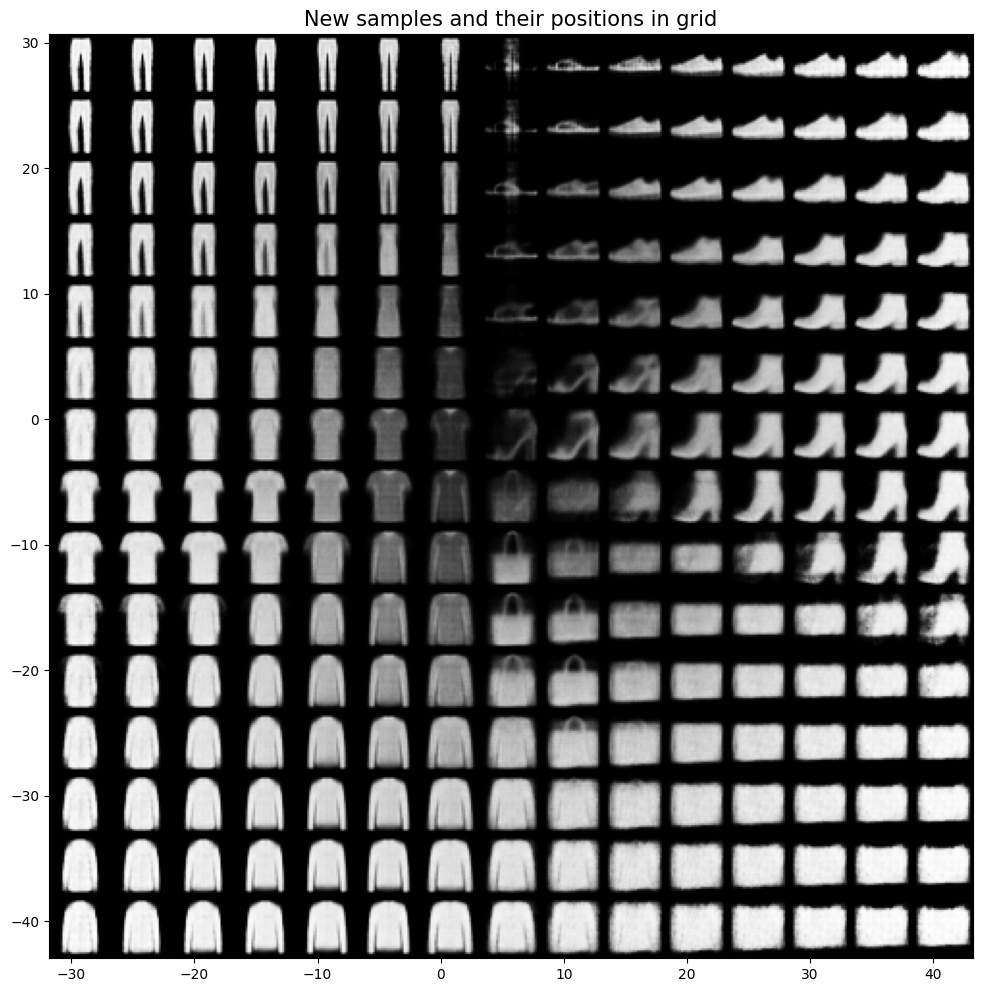

In [86]:
grid_size = 15
figsize = 12

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)

plt.figure(figsize=(figsize, figsize))
plt.title('New samples and their positions in grid', fontsize=15)

x_range = maxs[0] - mins[0]
y_range = maxs[1] - mins[1]
aspect_ratio = x_range / y_range

plt.xlim(mins[0], maxs[0])
plt.ylim(mins[1], maxs[1])

composite_image = np.vstack([np.hstack(row) for row in np.split(reconstructions, grid_size)])
plt.imshow(composite_image, cmap="gray", alpha=1.0, extent=(mins[0], maxs[0], mins[1], maxs[1]), aspect=aspect_ratio)

plt.show()

8/8 [==============================] - 0s 4ms/step


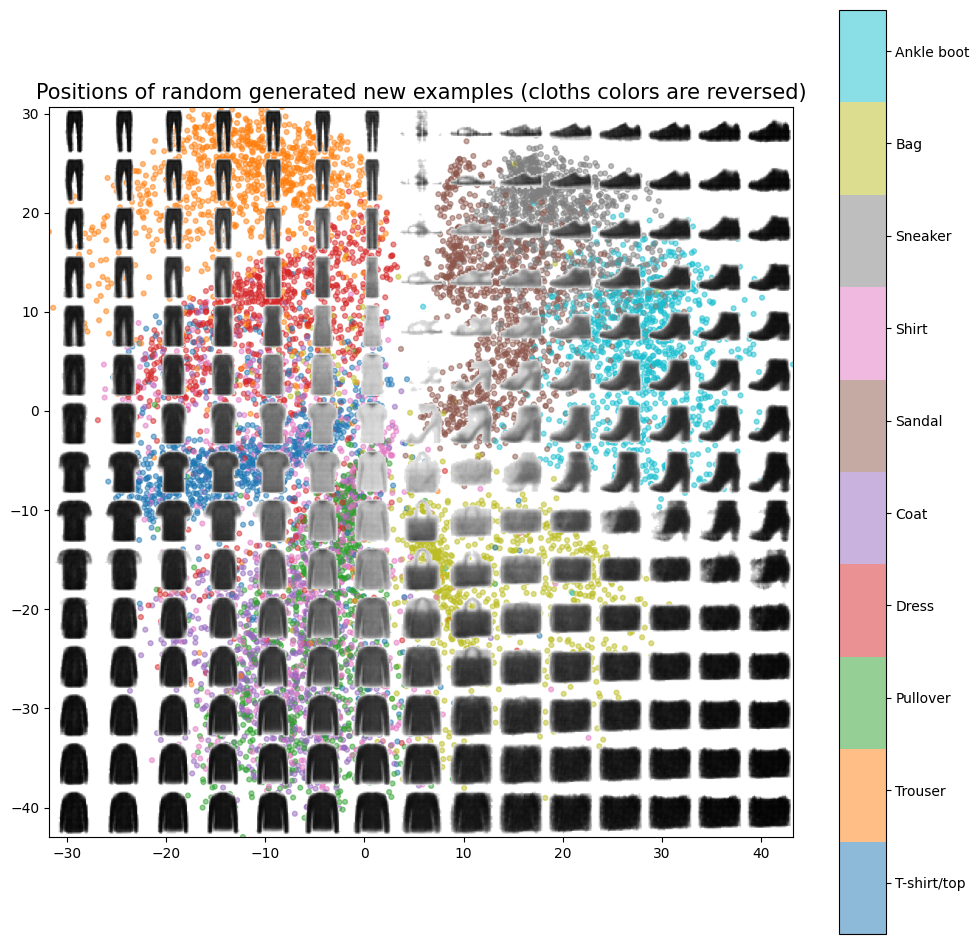

In [87]:
grid_size = 15
figsize = 12

x = np.linspace(min(embeddings[:, 0]), max(embeddings[:, 0]), grid_size)
y = np.linspace(max(embeddings[:, 1]), min(embeddings[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

reconstructions = decoder.predict(grid)
composite_image = np.vstack([np.hstack(row) for row in np.split(reconstructions, grid_size)])

# Specify the transparency threshold here
threshold = 0.9

# Remove the extra dimension from composite_image
composite_image = 1 - composite_image
composite_image = np.squeeze(composite_image)

# Create an alpha channel based on the defined threshold
alpha_channel = (composite_image < threshold).astype(float)

# Transform the grayscale image into an RGB format
composite_image_rgb = np.stack([composite_image]*3, axis=-1)

# Combine the RGB image and the alpha channel to form an RGBA image
composite_image_rgba = np.concatenate([composite_image_rgb, alpha_channel[..., None]], axis=-1)

figsize = 12
colors = sns.color_palette("tab10", n_colors=len(CLASS_NAMES))

fig, ax = plt.subplots(figsize=(figsize, figsize))
plt.title('Positions of random generated new examples (cloths colors are reversed)', fontsize=15)

plt.scatter(
  embeddings[:, 0],
  embeddings[:, 1],
  cmap=ListedColormap(colors),
  c=y_test,
  alpha=0.5,
  s=12,
  zorder=1
)

# Points that have been sampled
extent = [min(embeddings[:, 0]), max(embeddings[:, 0]), min(embeddings[:, 1]), max(embeddings[:, 1])]
ax.imshow(composite_image_rgba, extent=extent, zorder=2)

# Align the class names in the center of the color bar
num_ticks = len(CLASS_NAMES)
tick_positions = [i * (num_ticks - 1) / (num_ticks) + 0.5 for i in range(num_ticks)]
plt.colorbar(ticks=tick_positions).set_ticklabels(CLASS_NAMES)

plt.show()